# Approximate Nearest Neighbours

Today “Nearest Neighbor” has become a hot research topic, in order to increase the chance of users to find the information they are looking for in reasonable time

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

import faiss

import torch
from torchvision import datasets, transforms

from annoy import AnnoyIndex

## Пример диаграммы Вороного

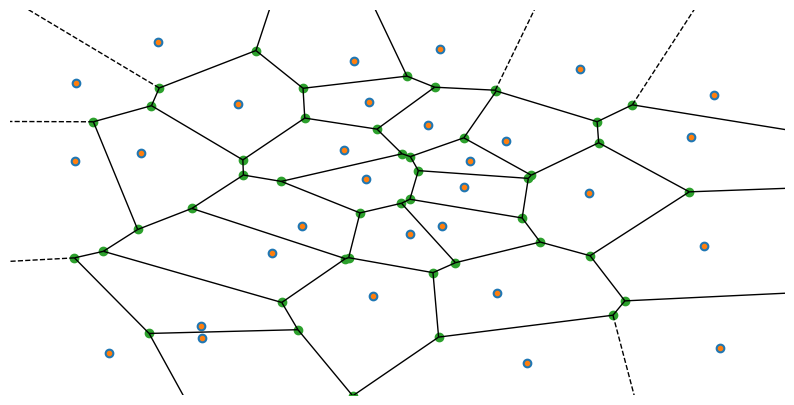

In [3]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Генерируем случайные точки для демонстрации
np.random.seed(0)
points = np.random.rand(30, 2)

# Создаем объект Voronoi
vor = Voronoi(points)

# Отрисовываем диаграмму Вороного
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(points[:, 0], points[:, 1], 'o')  # Отрисовка исходных точек
voronoi_plot_2d(vor, ax=ax)  # Отрисовка диаграммы Вороного
ax.axis('off')
# fig.savefig('./img/voronoy.jpg')
plt.show()

# FAISS for texts

## Step 1: Create a dataframe with the existing text and categories

In [4]:
data = [
['Where are your headquarters located?', 'location'],
['Throw my cellphone in the water', 'random'],
['Network Access Control?', 'networking'],
['Address', 'location'],
['Location plays a crucial role in determining the success of a retail business.', 'location'],
['The accuracy of location data is essential for effective navigation and mapping applications.', 'location'],
['In the era of mobile apps, users often share their location for personalized services and recommendations.', 'location'],
['Geospatial technology has revolutionized how we perceive and utilize location-based information.', 'location'],
['Location-based services contribute to enhanced user experiences by delivering context-aware content and functionality.', 'location'],
['A robust network infrastructure is vital for seamless communication in the modern digital era.', 'networking'],
['Network security measures are crucial to protect sensitive information from unauthorized access.', 'networking'],
['The expansion of 5G networks is driving faster and more reliable connectivity worldwide.', 'networking'],
['Network congestion can impact the speed and efficiency of data transfer in high-traffic environments.', 'networking'],
['Collaborative efforts among devices in a network enable efficient sharing of resources and information.', 'networking']
]
df = pd.DataFrame(data, columns = ['text', 'category'])
df

,text,category
0,Where are your headquarters located?,location
1,Throw my cellphone in the water,random
2,Network Access Control?,networking
3,Address,location
4,Location plays a crucial role in determining t...,location
5,The accuracy of location data is essential for...,location
6,"In the era of mobile apps, users often share t...",location
7,Geospatial technology has revolutionized how w...,location
8,Location-based services contribute to enhanced...,location
9,A robust network infrastructure is vital for s...,networking


## Step 2: Create vectors from the text

Using the text column of the dataframe, word embeddings or vectors are generated for each row using the `SentenceTransformer` framework. 

This is just one of the libraries available for transformation among others like doc2vec.

In [5]:
text = df['text']
encoder = SentenceTransformer("paraphrase-mpnet-base-v2")
vectors = encoder.encode(text)

## Step 3: Build a FAISS index from the vectors

Using the dimension of the vector (768 in this case), an L2 distance index is created, and L2 normalized vectors are added to that index. 

In FAISS, an index is an object that makes similarity searching efficient.

In [6]:
vector_dimension = vectors.shape[1]
index = faiss.IndexFlatL2(vector_dimension)
faiss.normalize_L2(vectors)
index.add(vectors)

## Step 4: Create a search vector

Let’s say we now want to search for the sentence that is most similar to our search text ‘where is your office?’. 

Using the same method of vectorization from step 2, a search text is transformed. Then the vector is also normalized because all the vectors within the search index are normalized.

In [7]:
search_text = 'where is your office?'
search_vector = encoder.encode(search_text)
_vector = np.array([search_vector])
faiss.normalize_L2(_vector)


## Step 5: Search

In this case, we want to search for all nearest neighbours, so k is set to the total number of vectors within the index.

In [8]:
k = index.ntotal
distances, ann = index.search(_vector, k=k)
results = pd.DataFrame({'distances': distances[0], 'ann': ann[0]})
results.sort_values('distances', inplace=True)
results

,distances,ann
0,0.584873,0
1,1.175950,3
2,1.433775,6
3,1.510146,8
4,1.518183,13
5,1.573957,4
6,1.644265,2
7,1.649230,9
8,1.665315,10
9,1.711215,12


## Step 7: Get category for the search text

In [9]:
# join by: df1.ann == data. index
merge = pd.merge( results, df, left_on= 'ann',
right_index=True)
merge.sort_values('distances', inplace=True)
merge

,distances,ann,text,category
0,0.584873,0,Where are your headquarters located?,location
1,1.175950,3,Address,location
2,1.433775,6,"In the era of mobile apps, users often share t...",location
3,1.510146,8,Location-based services contribute to enhanced...,location
4,1.518183,13,Collaborative efforts among devices in a netwo...,networking
5,1.573957,4,Location plays a crucial role in determining t...,location
6,1.644265,2,Network Access Control?,networking
7,1.649230,9,A robust network infrastructure is vital for s...,networking
8,1.665315,10,Network security measures are crucial to prote...,networking
9,1.711215,12,Network congestion can impact the speed and ef...,networking


# FAISS for image search

In [10]:
# Загрузка набора данных Fashion MNIST
transform = transforms.Compose([transforms.ToTensor()])
fashion_mnist = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(fashion_mnist, batch_size=len(fashion_mnist), shuffle=False)

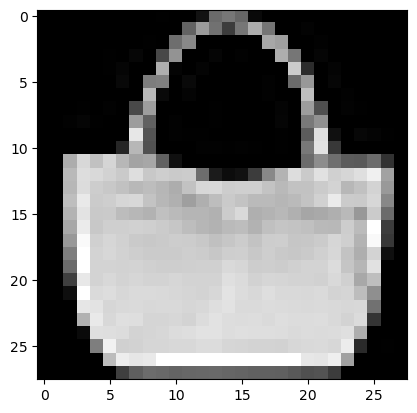

In [11]:
query_img, _ = fashion_mnist[100]
# Визуализация изображения
plt.imshow(query_img.squeeze(), cmap='gray')
plt.show()

In [12]:
# Получение признаков всех изображений в наборе
all_features = []
all_labels = []

# Простая сверточная сеть для извлечения признаков
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(14 * 14 * 32, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
    torch.nn.Softmax(dim=1)
)
model.eval()

for images, labels in data_loader:
    with torch.no_grad():
        features = model(images)
        all_features = features.numpy()
        all_labels = labels.numpy()


In [13]:
query_image_tensor = torch.unsqueeze(query_img, dim=0)
with torch.no_grad():
    query_features = model(query_image_tensor)

# Создание индекса FAISS
index = faiss.IndexFlatL2(query_features.shape[1])  # L2 расстояние
index.add(all_features)

In [14]:
# Поиск ближайших соседей для запроса
k = 5  # количество ближайших соседей
D, I = index.search(query_features.numpy(), k)

Индексы ближайших соседей: [[  100 37735 17988 56027  8354]]
Расстояния до ближайших соседей: [[3.8857806e-16 3.2269522e-06 3.4512150e-06 3.8064607e-06 4.3336263e-06]]


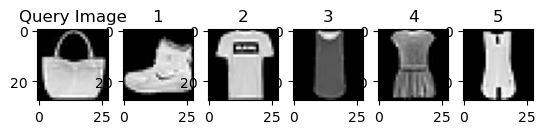

In [15]:
# Вывод результатов
print("Индексы ближайших соседей:", I)
print("Расстояния до ближайших соседей:", D)

# Визуализация запроса и ближайших соседей
plt.subplot(1, k + 1, 1)
plt.imshow(np.squeeze(query_img, axis=0), cmap='gray')
plt.title('Query Image')

for i in range(k):
    plt.subplot(1, k + 1, i + 2)
    same_img, _ = fashion_mnist[i]
    
    plt.imshow(same_img.squeeze(), cmap='gray')
    plt.title(f'{i+1}')

plt.show()

# Ускорение на больших датасетах

В предыдущих примерах мы искали по полному индексу. Теперь попробуем искать по приближенно.

In [54]:
# размерность тестовых векторов
dim = 512
nq = 5 # количество векторов в выборке для поиска
topn = 7
query = np.random.random((nq, dim)).astype('float32')
vectors = np.random.random((1000000, dim)).astype('float32')

In [55]:
print(f'Size of vectors array {vectors.nbytes/1024/1024/1024:2.3f} Gb')

Size of vectors array 1.907 Gb


## Делаем в тупую

In [56]:
vector_dimension = vectors.shape[1]
index = faiss.IndexFlatL2(vector_dimension)
faiss.normalize_L2(vectors)
index.add(vectors)

In [57]:
# Запускаем обучение:
index.train(vectors)  # Train на нашем наборе векторов

In [58]:
%%time
D, I = index.search(query, topn)

CPU times: user 349 ms, sys: 1.84 ms, total: 351 ms
Wall time: 72.5 ms


## IVF index

In [59]:
%%time
index = faiss.index_factory(dim, 'IVF1000,Flat')

CPU times: user 584 µs, sys: 23 ms, total: 23.6 ms
Wall time: 24.3 ms


In [60]:

# Запускаем обучение:
index.train(vectors)  # Train на нашем наборе векторов

# Обучение завершено, но векторов в индексе пока нет, так что добавляем их в индекс:
print(f'Num items in index: {index.ntotal:5.3f}')
index.add(vectors)
print(f'Num items in index after adding our vectors: {index.ntotal:8.0f}')

Num items in index: 0.000
Num items in index after adding our vectors:  1000000


In [61]:
%%time
D, I = index.search(query, topn)

CPU times: user 802 µs, sys: 669 µs, total: 1.47 ms
Wall time: 553 µs


In [62]:
print(f'Index:\n{I}')
print(f'Vectors:\n{D}')

Index:
[[312904   7633 139738 717000 521829 251267 881216]
 [522454 992973  39744 885056 155113 303769 783389]
 [ 17317 542677 757932 441358 620820 891772  61383]
 [924520 705120 173274 708642 929994 519237 725857]
 [150251 786439 533803  75237 552007 660574 774414]]
Vectors:
[[153.45776 153.45827 153.78638 153.78922 154.03307 154.03558 154.12764]
 [152.93799 153.0783  153.10571 153.2215  153.32498 153.41766 153.45111]
 [157.13223 157.64178 157.71289 157.78253 157.78477 157.82153 157.82922]
 [148.56097 148.57986 148.74265 148.81598 148.8889  148.93423 149.0941 ]
 [154.4024  154.5727  154.87791 154.96675 154.98607 155.07153 155.21527]]


Проблема - поиск велся только в одном кластере

Попробуем поискать по нескольким кластерам:

In [63]:
index.nprobe = 16  # Проходим по топ-16 центроид для поиска top-n ближайших соседей

In [64]:
%%time
D, I = index.search(query, topn) 

CPU times: user 4.59 ms, sys: 1.09 ms, total: 5.68 ms
Wall time: 1.87 ms


## Квантизация индекса

In [65]:
index = faiss.index_factory(dim, "IVF1000,PQ64", faiss.METRIC_L2)

In [66]:
# Запускаем обучение:
index.train(vectors)

index.add(vectors)

In [67]:
%%time
D, I = index.search(query, topn)

CPU times: user 1.09 ms, sys: 1.32 ms, total: 2.41 ms
Wall time: 1.09 ms


In [68]:
index.nprobe = 16  # Проходим по топ-16 центроид для поиска top-n ближайших соседей

In [69]:
%%time
D, I = index.search(query, topn) 

CPU times: user 1.86 ms, sys: 740 µs, total: 2.6 ms
Wall time: 622 µs


Применение IVF индекса и квантизации уменьшило время выполнения поиска

# ScaNN

Показываем в GoogleColab (потому что на Mac M1 надо собирать из исходников)

# Annoy

In [70]:
%%time
# Построение индекса Annoy
index = AnnoyIndex(512, metric='angular')  # 'angular' используется для косинусного расстояния

[index.add_item(i[0], i[1]) for i in enumerate(vectors)]

index.build(10)  # Параметр - число деревьев в индексе, может потребоваться настройка

CPU times: user 2min 18s, sys: 1.56 s, total: 2min 20s
Wall time: 41.3 s


True

In [71]:
%%time
# Поиск ближайших соседей
I, D = index.get_nns_by_vector(query[0], topn, search_k=-1, include_distances=True)

CPU times: user 653 µs, sys: 229 µs, total: 882 µs
Wall time: 403 µs
